In [5]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field1', 'Field2', 'Field3', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'Field13', 'FieldA', 'FieldB', 'FieldC', 'FieldD', 'FieldE', 'FieldF', 'FieldG', 'FieldH', 'FieldI', 'FieldK', 'FieldL', 'FieldM', 'FieldO', 'FieldP', 'FieldQ', 'FieldR', 'FieldS', 'FieldT', 'FieldU', 'FieldV', 'FieldW', 'FieldX', 'FieldY', 'H_North', 'H_South', 'ArchE', 'ArchNE', 'ArchNW', 'ArchSE', 'ArchW']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [6]:
#import configuration for selected file
from config import Field3 as field
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [7]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9

In [8]:
def performApPhoto(data,wcs,sourceCoords,radii,plot=True):
	#first let's do some simple annulus extractions...   
	apertures =[SkyCircularAperture(sourceCoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

	#do aperture photometry on data using defined apertures 
	phot_table = aperture_photometry(data, apertures,wcs=wcs,error=errormap,method='exact')

	#display phot table
	#phot_table

	#now try photometry with local background subtraction
	aperture2 =SkyCircularAperture(sourceCoords, r=6*u.arcsec) #define aperture
	annulus_aperture = SkyCircularAnnulus(sourceCoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

	#convert to pixel coords for plotting
	pix_aperture = aperture2.to_pixel(wcs)
	pix_annulus_aperture = annulus_aperture.to_pixel(wcs)
    
	#print(pix_aperture)

	if plot:
		#show figure with apertures overlayed
		plt.figure(figsize=(8,8))
		norm = simple_norm(data, 'sqrt', percent=99)
		plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
		plt.colorbar()
		#plt.xlim(40, 140)
		#plt.ylim(50, 125)

		ap_patches = pix_aperture.plot(color='white', lw=2,
 	                          label='Photometry aperture')
		ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
		                                    label='Background annulus')
		handles = (ap_patches[0], ann_patches[0])
		plt.legend(loc='best', facecolor='#458989', labelcolor='white',
		           handles=handles, prop={'weight': 'bold', 'size': 11})
		plt.show()

	#now lets do robust statistics on the background annuli


	#create lists to store information for later
	bkg_median=[]
	bkg_mean=[]
	bkg_std=[]
	appmasks=[]


	#create mask array for the annuli
	annulus_masks = pix_annulus_aperture.to_mask(method='exact')

	#for each of the annuli loop through and calculate stats using sigma cliped stats
	for mask in annulus_masks:
		annulus_data = mask.multiply(data)
		#print(np.shape(mask))
        
		#this is a bit of debugging to handle if the mask array is the wrong shape
		if np.shape(mask.data)[0]==41:
			maskdata=mask.data[:-1,:]
		else:
			maskdata=mask.data
        
		#do statistics
		annulus_data_1d = annulus_data[maskdata > 0]
		meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
		bkg_median.append(median_sigclip)
		bkg_mean.append(meansc)
		bkg_std.append(stdsc)
		appmasks.append(mask.data)

	#store values in numpy arrays
	bkg_median = np.array(bkg_median)
	bkg_mean = np.array(bkg_mean)
	bkg_std = np.array(bkg_std)

	#do aperture photometry
	phot_table2 = aperture_photometry(data, aperture2,wcs=wcs,error=errormap,method='exact') #

	#add columns for background information and also background subtracted apertures
	phot_table2['ann_bkg_med'] = bkg_median
	phot_table2['ann_bkg_mean'] = bkg_mean 
	phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
	phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
	#not sure if the above is right for the error array...

	#calculate sky noise for 6 pixel aperture
	skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
	sna=np.array(skynoise)
	masknan=np.isnan(sna)
	sna[masknan]=0.0
	skynoise=sna**2

	#store per pix sky noise for later
	phot_table2['skynoise_pix']=skynoise/pix_aperture.area

	#shot noise from the source
	sourcenoise=phot_table2['aper_sum_bkgsub_6as']

	#thermal noise from camera (from error map)
	thermalnoise=phot_table2['aperture_sum_err']
    
	#save these for later use
	phot_table2['pixApArea']=pix_aperture.area
	phot_table2['pixAnnArea']=pix_annulus_aperture.area

	#compute total noise 
	#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
	#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
	totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

	#SNR calc for 6 pixel aperture
	phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise
    
	merged_table = join(phot_table, phot_table2, keys='id')

	return merged_table

In [9]:
def modTabCol(merged_table):
	merged_table.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])
	
	#rename some columns to avoid possible confusion
	merged_table.rename_column('aperture_sum_0', 'aperture_sum_2as')
	merged_table.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
	merged_table.rename_column('aperture_sum_1', 'aperture_sum_4as')
	merged_table.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
	merged_table.rename_column('aperture_sum_2', 'aperture_sum_6as')
	merged_table.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
	merged_table.rename_column('aperture_sum_3', 'aperture_sum_8as')
	merged_table.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
	merged_table.rename_column('aperture_sum_4', 'aperture_sum_10as')
	merged_table.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')
	
	
	#compute area for the different size apertures 
	ap2area=merged_table['pixApArea']*(2./6.)**2
	ap4area=merged_table['pixApArea']*(4./6.)**2
	#ap6area=merged_table['pixApArea']*(6./6.)**2
	ap8area=merged_table['pixApArea']*(8./6.)**2
	ap10area=merged_table['pixApArea']*(10./6.)**2
	
	
	#calculate local bkg subtracted photometry for the other apertures 
	merged_table['aper_sum_bkgsub_2as']=(merged_table['aperture_sum_2as']/ap2area-merged_table['ann_bkg_med'])*ap2area
	merged_table['aper_sum_bkgsub_4as']=(merged_table['aperture_sum_4as']/ap4area-merged_table['ann_bkg_med'])*ap4area
	#merged_table['aper_sum_bkgsub_6as']=(merged_table['aperture_sum_6as']/ap6area-merged_table['ann_bkg_med'])*ap6area
	merged_table['aper_sum_bkgsub_8as']=(merged_table['aperture_sum_8as']/ap8area-merged_table['ann_bkg_med'])*ap8area
	merged_table['aper_sum_bkgsub_10as']=(merged_table['aperture_sum_10as']/ap10area-merged_table['ann_bkg_med'])*ap10area
	
	#calculate snr for each aperture
	merged_table['aper_snr_2as']=merged_table['aper_sum_bkgsub_2as']/np.sqrt((merged_table['aperture_sum_err_2as']+merged_table['skynoise_pix']*ap2area)*(1+ap2area/merged_table['pixAnnArea']))
	merged_table['aper_snr_4as']=merged_table['aper_sum_bkgsub_4as']/np.sqrt((merged_table['aperture_sum_err_4as']+merged_table['skynoise_pix']*ap4area)*(1+ap4area/merged_table['pixAnnArea']))
	#merged_table['aper_snr_6as']=merged_table['aper_sum_bkgsub_6as']/np.sqrt((merged_table['aperture_sum_err_6as']+merged_table['skynoise_pix']*ap6area)*(1+ap6area/merged_table['pixAnnArea']))
	merged_table['aper_snr_8as']=merged_table['aper_sum_bkgsub_8as']/np.sqrt((merged_table['aperture_sum_err_8as']+merged_table['skynoise_pix']*ap8area)*(1+ap8area/merged_table['pixAnnArea']))
	merged_table['aper_snr_10as']=merged_table['aper_sum_bkgsub_10as']/np.sqrt((merged_table['aperture_sum_err_10as']+merged_table['skynoise_pix']*ap10area)*(1+ap10area/merged_table['pixAnnArea']))
	
	#calculate max snr for all apertures
	snr_values=np.array(merged_table['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
	snr_values.dtype=np.float
	snr_values=np.reshape(snr_values, (-1,5))
	maxsnr=np.nanmax(snr_values,axis=1)
	merged_table['aper_snr_max']=maxsnr
	
	#add additonal information for wavelength and which field 
	merged_table['Field']='C7'+field.name
	merged_table['wv']=wavelength
	
	#display table
	return merged_table

In [10]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

In [11]:
#load in the catalog files if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_seg.dat'):
    segTab=ascii.read(field.name+'_'+str(wavelength)+'um_seg.dat')
else:
    segTab=None
    
if os.path.isfile(field.name+'_'+str(wavelength)+'um_dao.dat'):   
    daoTab=ascii.read(field.name+'_'+str(wavelength)+'um_dao.dat')
else:
    daoTab=None

In [12]:
#Source coordinates need to be in the form of skycoord objects to create apertures. Ascii tables save as strings so this code puts them back in the right form. 
if segTab is not None:
    sourcecoords=segTab['sky_centroid']
else:
    sourcecoords=[]
scseg=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scseg.append(scobj)

if segTab is not None:
    segTab['skycoords']=scseg
    sourcesseg=segTab['skycoords']

sourcecoords=daoTab['sky_centroid']
scdao=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scdao.append(scobj)
    
daoTab['skycoords']=scdao
sourcesdao=daoTab['skycoords']

In [13]:
#check if user defined ds9 file exists
if os.path.isfile(field.name+'_ds9.reg'):
    sourcesDS9=read_ds9(field.name+'_ds9.reg')

    clist=[]
    
    for source in sourcesDS9:
        if source.visual['color']=='green':
            sc=source.center
            ra=sc.ra.value
            dec=sc.dec.value
            a=(ra,dec)
            clist.append(a)
            
    ds9sc=SkyCoord(clist,unit=u.deg)
    usersources=True
    print('Number of user defined DS9 sources found: ', len(clist))  
else:
    usersources=False
    print('No user defined DS9 sources found')

No user defined DS9 sources found


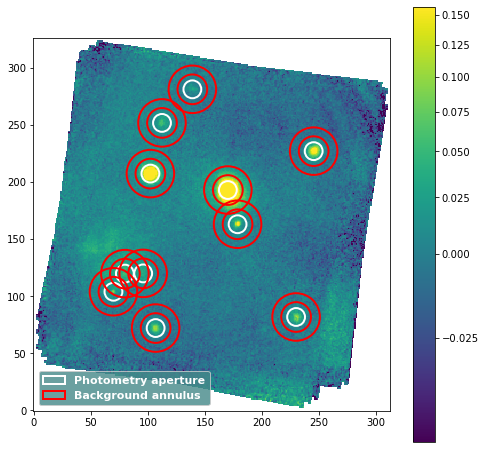

<ipython-input-8-2df52ea64775>:87: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


In [14]:
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)

if segTab is not None:
    SegPhotTable=performApPhoto(data,wcsmap,sourcesseg,radii,plot=True)

    #display the photometry table
    SegPhotTable
else:
    print('No sources found in segmentation map')

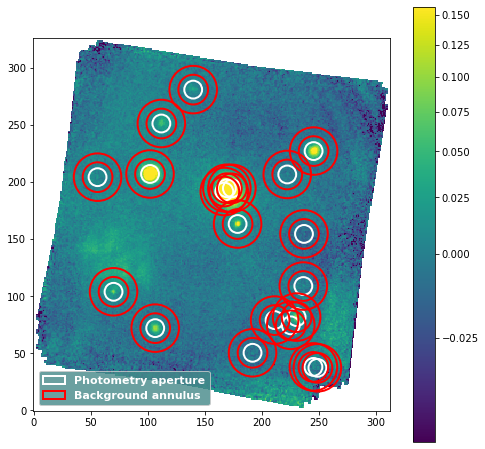

<ipython-input-8-2df52ea64775>:87: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter_1,ycenter_1,sky_center_1,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4,xcenter_2,ycenter_2,sky_center_2,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,,,,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,244.9771844446667,38.05881796787435,"266.22941595781793,-29.30102122320346",0.049552904240353975,0.05774024753319274,-0.10533278963362762,0.1180983654562754,-0.23980961598080094,0.18302400170126987,-0.32050858873722354,0.2553007718749096,-0.16710823475635728,0.33114927773429415,244.9771844446667,38.05881796787435,"266.22941595781793,-29.30102122320346",-0.23980961598080094,0.18302400170126987,0.0017596957937063894,0.002672816535869602,-0.5772270526482854,0.18302400170126987,0.0017596957937063896,191.74759516631747,830.906245720709,-0.7212277484448129
2,248.4866163462528,37.25236134133297,"266.2285573983557,-29.30119310774754",-0.03267794253093665,0.06762566272860167,-0.1799310351757997,0.1410031317327628,-0.19354704491246666,0.2166411997535845,-0.4010761377363252,0.2919985012134069,-0.14648046949935223,0.37432157965861457,248.4866163462528,37.25236134133297,"266.2285573983557,-29.30119310774754",-0.19354704491246666,0.2166411997535845,0.0018156287266483816,0.0028580871997089517,-0.541689486962177,0.2166411997535845,0.0018156287266483816,191.74759516631747,830.906245720709,-0.6497122227435163
3,191.63014333877513,50.42879977938796,"266.2424666088127,-29.298384042570675",-0.06889728128202059,0.04400353861257188,-0.44224391212049774,0.08821615723792195,-1.0878825945467767,0.13496292565651555,-2.380754395081141,0.18392491575625644,-4.047876956217457,0.23440017837659313,191.63014333877513,50.42879977938796,"266.2424666088127,-29.298384042570675",-1.0878825945467767,0.13496292565651555,-0.005069838371127844,-0.005594974407571385,-0.11575327900109249,0.13496292565651555,0.0,191.74759516631747,830.906245720709,-0.28401268992357004
4,106.31560393480945,72.04206977265058,"266.2633362523235,-29.29377337151154",1.7868327234071526,0.043729878812692594,4.262159024030283,0.08743688962836017,5.522956024354931,0.13108726518624597,5.617512198883595,0.174644580060421,4.980537791293546,0.21826924217724822,106.31560393480945,72.04206977265058,"266.2633362523235,-29.29377337151154",5.522956024354931,0.13108726518624597,-0.0045493888547179125,-0.005237927375639551,6.395290396723539,0.13108726518624597,0.0,191.74759516631747,830.906245720709,15.921783087441264
5,225.14005424506797,74.49855953814246,"266.234270235401,-29.293248211769566",0.17082389416804888,0.045363071622426226,0.6721233686653102,0.09075544452256247,2.0615330161413983,0.13612117802244877,3.986890790750488,0.18140651214313042,5.520266828553481,0.226584165586138,225.14005424506797,74.49855953814246,"266.234270235401,-29.293248211769566",2.0615330161413983,0.13612117802244877,7.317802374018356e-05,0.0004977296774753058,2.0475013060701945,0.13612117802244877,7.317802374018355e-05,191.74759516631747,830.906245720709,4.762873284117613
6,210.95890145180914,79.11161187616615,"266.23773928098575,-29.292264557057145",0.06526180638199756,0.044779368327408156,-0.01991044077400049,0.0895923065039751,-0.23266500009046875,0.1344840869965419,-0.4006220167367411,0.179412925213234,-0.4119238429085086,0.224273206856968,210.95890145180914,79.11161187616615,"266.23773928098575,-29.292264557057145",-0.23266500009046875,0.1344840869965419,-0.0019492172095059847,-0.002283478296682356,0.1410927122891038,0.1344840869965419,0.0,191.74759516631747,830.906245720709,0.34680138046918285
7,230.2655148318657,81.72368477976738,"266.2330167981546,-29.291706662625344",1.737237

In [15]:
DaoPhotTable=performApPhoto(data,wcsmap,sourcesdao,radii,plot=True)

#display the table
DaoPhotTable

In [16]:
if usersources:
    UserPhotTable=performApPhoto(data,ds9sc,radii,plot=True)

    #display the table
    UserPhotTable

In [17]:
#fix id keywords in tables so theu can be merged
try:
    segTab.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

#try:
#    daoTab.rename_column('label', 'id')
#except:
#    print('Do nothing because keyword is already changed.')

In [18]:
#merge Tables
merged_table_seg = join(segTab, SegPhotTable, keys='id')
merged_table_dao = join(daoTab, DaoPhotTable, keys='id')

In [19]:
mtSeg=modTabCol(merged_table_seg)
mtDao=modTabCol(merged_table_dao)

if usersources:
    mtds9=modTabCol(UserPhotTable)


In [20]:
#write out the resulting tables to file
ascii.write(mtSeg, field.name+'_'+str(wavelength)+'um_segCat.dat', overwrite=True)
ascii.write(mtDao, field.name+'_'+str(wavelength)+'um_daoCat.dat', overwrite=True)

if usersources:
    ascii.write(mtds9, field.name+'_'+str(wavelength)+'um_usrCat.dat', overwrite=True)